In [1]:
#import
import sys

import pandas as pd
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

sys.path.append('../')
from pyopt.util import fft, ifft, save_pickle, load_pickle, sampling_signal

In [2]:
def load_signal(signal_info, trans_condition, n, Lmax):
    if signal_info['signal_type'] == 'prbs':
        return load_prbs(signal_info, trans_condition, n, Lmax)
    elif signal_info['signal_type'] == 'random':
        return load_random(signal_info, trans_condition, n, Lmax)
    elif signal_info['signal_type'] == 'image':
        return load_image(signal_info, trans_condition, n, Lmax)

In [3]:
def load_prbs(signal_info, trans_condition, n, Lmax):
    N = signal_info['N']
    itr = signal_info['itr']
    signal_condition = 'N=='+str(N)+'&itr=='+str(itr)
    signal_list = [N, itr] + [None] * 6
    
    # prbs.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'prbs.csv', index_col=0)
    
    # prbs.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if prbs.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        return
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        return sgnl

In [4]:
def load_random(signal_info, trans_condition, n, Lmax):
    seed = signal_info['seed']
    bit_num = signal_info['bit_num']
    signal_condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    signal_list = [None] * 2 + [seed, bit_num] + [None] * 4
    
    # random.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'random.csv', index_col=0)
    
    # random.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if random.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        return
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        return sgnl

In [5]:
def load_image(signal_info, trans_condition, n, Lmax):
    target_dir = signal_info['target_dir']
    step = signal_info['step']
    image_number = signal_info['image_number']
    ebtb = signal_info['ebtb']
    signal_condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)
    signal_list = [None] * 4 + [target_dir, step, image_number, ebtb]
    
    # image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'image.csv', index_col=0)
    
    # image.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query('target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number+'&ebtb=='+str(ebtb) + '&' + trans_condition)

    # if image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        return
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
    return sgnl

In [6]:
class DBP_runge_kutta:
    def __init__(self, sgnl, sampling, stepdbp):
        self.sgnl = sgnl
        self.n_transmission = self.sgnl.n
        self.sampling = sampling
        self.stepdbp = stepdbp
        
        self.input = sampling_signal(self.sgnl.signal['x_0'], self.n_transmission, self.sampling)
        
        self.sgnl.length = self.sgnl.length // self.sgnl.n * self.sampling
        self.sgnl.n = sampling
        self.sgnl.Frequency = self.sgnl._frequency()  # 周波数軸[GHz]
        self.sgnl.Lambda = self.sgnl._wavelength()  # 波長軸[nm]
        self.sgnl.Omega = self.sgnl._omegafrequency() * 10 ** -9
    
    def dbp(self, Lmax=1000):
        self.nlc = sampling_signal(self.sgnl.signal['x_'+str(Lmax)], self.n_transmission, self.sampling)
        for _ in tqdm(range(Lmax // self.sgnl.Ledfa)):
            self.dbp_1span()
        
    def dbp_1span(self):
        self.nlc /= 10 ** (self.sgnl.Alpha * self.sgnl.Ledfa / 10)
        self.nlc = self._digital_back_propagation(self.nlc)
    
    def _runge_kutta(self, L, x, y=None):
        if y is None:
            k1 = self.sgnl._sf(x) * L
            k2 = self.sgnl._sf(x + k1 / 2) * L
            k3 = self.sgnl._sf(x + k2 / 2) * L
            k4 = self.sgnl._sf(x + k3) * L
            xx = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
            x = x / np.exp(-1j * L / 2 * 2 * np.pi * self.sgnl.n2
                           / (self.sgnl.Lambda * 10 ** -9) * (abs(x ** 2) + abs(xx ** 2)))
        else:
            k1 = self.sgnl._sf(x, y) * L
            k2 = self.sgnl._sf(x + k1 / 2, y) * L
            k3 = self.sgnl._sf(x + k2 / 2, y) * L
            k4 = self.sgnl._sf(x + k3, y) * L
            xx = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
            x = x / np.exp(-1j * L / 2 * 2 * np.pi * self.sgnl.n2
                           / (self.sgnl.Lambda * 10 ** -9) * (abs(x) ** 2 + abs(xx) ** 2))
        return x
    
    def _digital_back_propagation(self, x, y=None):
        dL = self.sgnl.Ledfa / self.stepdbp  # dL[km] 区間一つの長さ
        dH = self.sgnl._H(dL / 2)  # dH 区間一つの半分における伝達関数
        ddL = dL * 10 ** 3  # ddL[m]

        for i in range(self.stepdbp):
            """伝搬損失の補償"""
            x = x * 10 ** (self.sgnl.Alpha * dL / 2 / 10)  # Alpha = 0.20dB/km dL = 100km のとき1/100
            
            """1区間の後半の周波数領域での線形歪を補償"""
            X = fft(x)
            X = X / dH
            x = ifft(X)

            """1区間の実時間領域での非線形効果による位相推移をルンゲ・クッタ法を用いて補償"""
            x = self._runge_kutta(ddL, x, y)
            
            """伝搬損失の補償"""
            x = x * 10 ** (self.sgnl.Alpha * dL / 2 / 10)  # Alpha = 0.20dB/km dL = 100km のとき1/100

            """1区間の後半の周波数領域での線形歪を計算"""
            X = fft(x)
            X = X / dH
            x = ifft(X)
        return x
    
    def cal_evm(self, input_signal, output_signal):
        symbol, index, inverse, counts = np.unique(input_signal, return_index=True, return_inverse=True, return_counts=True)
        
        t_sum = 0
        for i in range(len(index)):
            t_sum += abs(input_signal[index[i]])
        mean = t_sum / len(index)
        
        tmp = 0
        for i in range(len(output_signal)):
            tmp += abs(output_signal[i] - input_signal[i]) ** 2# / abs(input_signal[i]) ** 2
        evm = np.sqrt(tmp / len(output_signal)) / mean * 100
        return evm
    
    def cal_evm_min(self, input_signal, output_signal):
        symbol, index, inverse, counts = np.unique(input_signal, return_index=True, return_inverse=True, return_counts=True)
        
        t_sum = 0
        for i in range(len(index)):
            t_sum += abs(input_signal[index[i]])
        mean = t_sum / len(index)
        
        evm_min = 200
        i_min = 0
        for i in range(360):
            signal = output_signal * np.exp(1j * i * np.pi/180)
            tmp = 0
            for j in range(len(output_signal)):
                tmp += abs(signal[j] - input_signal[j]) ** 2# / abs(input_signal[j]) ** 2
            evm = np.sqrt(tmp / len(output_signal)) / mean * 100
            if evm < evm_min:
                evm_min = evm
                i_min = i
        return evm_min, i_min
    
    def cal_ber(self, input_signal, output_signal):
        evm = self.cal_evm(input_signal, output_signal)
        M = {'NRZQPSK': 4,
             'RZQPSK': 4,
             'NRZ16QAM': 16,
             'RZ16QAM': 16}
        ber = (1 - M[self.sgnl.form] ** (-1 / 2)) / (1 / 2 * np.log2(M[self.sgnl.form])) \
            * special.erfc(np.sqrt(3 / 2 / (M[self.sgnl.form] - 1) / (evm / 100) ** 2))
        return ber

    def cal_qfac(self, input_signal, output_signal):
        ber = self.cal_ber(input_signal, output_signal)
        q = 20 * np.log10(np.sqrt(2) * special.erfcinv(2 * ber))
        return q

In [7]:
class DBP:
    def __init__(self, sgnl, sampling, stepdbp):
        self.sgnl = sgnl
        self.n_transmission = self.sgnl.n
        self.sampling = sampling
        self.stepdbp = stepdbp
        
        self.input = sampling_signal(self.sgnl.signal['x_0'], self.n_transmission, self.sampling)
        
        self.sgnl.length = self.sgnl.length // self.sgnl.n * self.sampling
        self.sgnl.n = sampling
        self.sgnl.Frequency = self.sgnl._frequency()  # 周波数軸[GHz]
        self.sgnl.Lambda = self.sgnl._wavelength()  # 波長軸[nm]
        self.sgnl.Omega = self.sgnl._omegafrequency() * 10 ** -9
    
    def dbp(self, Lmax=1000):
        self.nlc = sampling_signal(self.sgnl.signal['x_'+str(Lmax)], self.n_transmission, self.sampling)
        for _ in tqdm(range(Lmax // self.sgnl.Ledfa)):
            self.dbp_1span()
        
    def dbp_1span(self):
        self.nlc /= 10 ** (self.sgnl.Alpha * self.sgnl.Ledfa / 10)
        self.nlc = self._digital_back_propagation(self.nlc)
    
    def _digital_back_propagation(self, x, y=None):
        dL = self.sgnl.Ledfa / self.stepdbp  # dL[km] 区間一つの長さ
        dH = self.sgnl._H(dL)  # dH 区間一つにおける伝達関数
        ddL = dL * 10 ** 3  # ddL[m]

        for i in range(self.stepdbp):
            """伝搬損失の補償"""
            x = x * 10 ** (self.sgnl.Alpha * dL / 10)  # Alpha = 0.20dB/km dL = 100km のとき1/100
            
            """1区間の周波数領域での線形歪を補償"""
            X = fft(x)
            X = X / dH
            x = ifft(X)

            """1区間の実時間領域での非線形効果による位相推移を補償"""
            x = x * np.exp(-1j * ddL * 2 * np.pi * self.sgnl.n2 / (self.sgnl.Lambda * 10 ** -9) * abs(x) ** 2)
            
        return x
    
    def cal_evm(self, input_signal, output_signal):
        symbol, index, inverse, counts = np.unique(input_signal, return_index=True, return_inverse=True, return_counts=True)
        
        t_sum = 0
        for i in range(len(index)):
            t_sum += abs(input_signal[index[i]])
        mean = t_sum / len(index)
        
        tmp = 0
        for i in range(len(output_signal)):
            tmp += abs(output_signal[i] - input_signal[i]) ** 2# / abs(input_signal[i]) ** 2
        evm = np.sqrt(tmp / len(output_signal)) / mean * 100
        return evm
    
    def cal_evm_min(self, input_signal, output_signal):
        symbol, index, inverse, counts = np.unique(input_signal, return_index=True, return_inverse=True, return_counts=True)
        
        t_sum = 0
        for i in range(len(index)):
            t_sum += abs(input_signal[index[i]])
        mean = t_sum / len(index)
        
        evm_min = 200
        i_min = 0
        for i in range(360):
            signal = output_signal * np.exp(1j * i * np.pi/180)
            tmp = 0
            for j in range(len(output_signal)):
                tmp += abs(signal[j] - input_signal[j]) ** 2# / abs(input_signal[j]) ** 2
            evm = np.sqrt(tmp / len(output_signal)) / mean * 100
            if evm < evm_min:
                evm_min = evm
                i_min = i
        return evm_min, i_min
    
    def cal_ber(self, input_signal, output_signal):
        evm = self.cal_evm(input_signal, output_signal)
        M = {'NRZQPSK': 4,
             'RZQPSK': 4,
             'NRZ16QAM': 16,
             'RZ16QAM': 16}
        ber = (1 - M[self.sgnl.form] ** (-1 / 2)) / (1 / 2 * np.log2(M[self.sgnl.form])) \
            * special.erfc(np.sqrt(3 / 2 / (M[self.sgnl.form] - 1) / (evm / 100) ** 2))
        return ber

    def cal_qfac(self, input_signal, output_signal):
        ber = self.cal_ber(input_signal, output_signal)
        q = 20 * np.log10(np.sqrt(2) * special.erfcinv(2 * ber))
        return q

In [8]:
def display_constellation(nnc, y):
    symbol, inverse, counts = np.unique(y, return_inverse=True, return_counts=True)
    cm = plt.get_cmap('rainbow', 16)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(symbol)):
        ax.plot(nnc[y == symbol[i]].real, nnc[y == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
    ax.set_xlim((-110000, 110000))
    ax.set_ylim((-110000, 110000))
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)
    plt.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)

In [9]:
def dbp_with_save(signal_info, stepdbp):
    form = signal_info['form']
    sampling = signal_info['sampling']
    PdBm = signal_info['PdBm']
    Lmax = signal_info['Lmax']
    
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか

    # 指定した伝送条件
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)

    sgnl = load_signal(signal_info, trans_condition, n, Lmax)
    
    dbp = DBP_runge_kutta(sgnl, sampling, stepdbp) # _runge_kutta
    dbp.dbp(Lmax)
    
    return dbp


44.14032521833357
35.122197957016006 15
3.1180576166628664


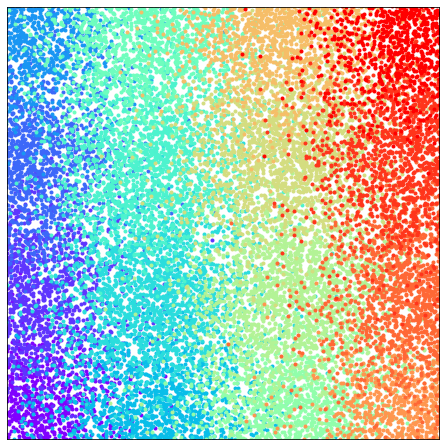

In [241]:
signal_info_prbs = {'signal_type': 'prbs', 'N': 17, 'itr': 1, 'form': 'RZ16QAM', 'sampling': 4, 'PdBm': 5, 'Lmax': 5000}
signal_info_image = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10', 'ebtb': True,
                     'form': 'RZ16QAM', 'sampling': 4, 'PdBm': 1, 'Lmax': 2500}
stepdbp = 1

dbp = dbp_with_save(signal_info_prbs, stepdbp)
evm = dbp.cal_evm(dbp.input[dbp.sampling // 2::dbp.sampling], dbp.nlc[dbp.sampling // 2::dbp.sampling])
evm_min, i_min = dbp.cal_evm_min(dbp.input[dbp.sampling // 2::dbp.sampling], dbp.nlc[dbp.sampling // 2::dbp.sampling])
print(evm)
print(evm_min, i_min)
nlc = dbp.nlc * np.exp(1j * i_min * np.pi/180)
qfac = dbp.cal_qfac(dbp.input[dbp.sampling // 2::dbp.sampling], nlc[dbp.sampling // 2::dbp.sampling])
print(qfac)
display_constellation(nlc[dbp.sampling // 2::dbp.sampling],dbp.input[dbp.sampling // 2::dbp.sampling])

20.933270568608076 344
7.041366672790072


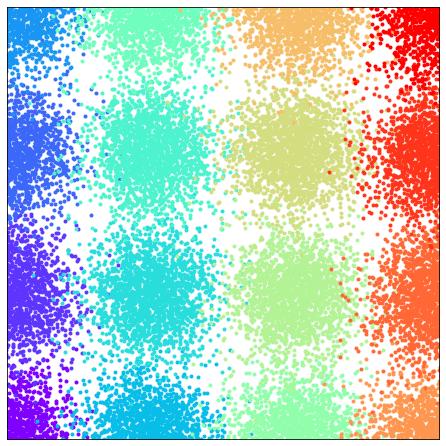

In [234]:
lc = sampling_signal(dbp.sgnl.signal['x_5000'], 32, dbp.sampling)
lc = dbp.sgnl.linear_compensation(5000, lc)
evm_min, i_min = dbp.cal_evm_min(dbp.sgnl.signal['x_0'][16::32], lc[dbp.sampling // 2::dbp.sampling])
print(evm_min, i_min)
lc = lc * np.exp(1j * i_min * np.pi/180)
qfac = dbp.cal_qfac(dbp.sgnl.signal['x_0'][16::32], lc[dbp.sampling // 2::dbp.sampling])
print(qfac)
display_constellation(lc[dbp.sampling // 2::dbp.sampling], dbp.sgnl.signal['x_0'][16::32])

2.5908836290683364


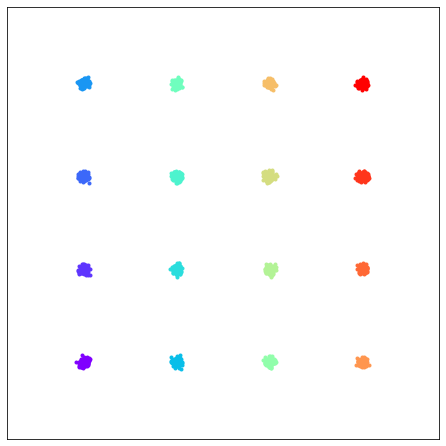

In [154]:
nlc = dbp.nlc * np.exp(1j * i_min * np.pi/180)
display_constellation(nlc[dbp.sampling // 2::dbp.sampling],dbp.input[dbp.sampling // 2::dbp.sampling])
evm = dbp.cal_evm(dbp.input[dbp.sampling // 2::dbp.sampling], nlc[dbp.sampling // 2::dbp.sampling])
print(evm)

In [16]:
signal_info_prbs = {'signal_type': 'prbs', 'N': 17, 'itr': 1, 'form': 'RZ16QAM', 'sampling': 32, 'PdBm': 1, 'Lmax': 5000}
signal_info_image0 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10', 'ebtb': True,
                     'form': 'RZ16QAM', 'sampling': 4, 'PdBm': 1, 'Lmax': 5000}
signal_info_image1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10', 'ebtb': False,
                     'form': 'RZ16QAM', 'sampling': 4, 'PdBm': 1, 'Lmax': 5000}
signal_info_image2 = {'signal_type': 'image', 'target_dir': 'train', 'step': 10, 'image_number': '9', 'ebtb': True,
                     'form': 'RZ16QAM', 'sampling': 4, 'PdBm': 1, 'Lmax': 5000}
signal_info_image3 = {'signal_type': 'image', 'target_dir': 'train', 'step': 10, 'image_number': '9', 'ebtb': False,
                     'form': 'RZ16QAM', 'sampling': 4, 'PdBm': 1, 'Lmax': 5000}
stepdbp = 30

Ls = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
evms = np.zeros((1, 10), dtype=float)
for i, L in enumerate(tqdm(Ls)):
    signal_info_prbs['Lmax'] = L
    
    dbp = dbp_with_save(signal_info_prbs, stepdbp)
    evm = dbp.cal_evm(dbp.input[dbp.sampling // 2::dbp.sampling], dbp.nlc[dbp.sampling // 2::dbp.sampling])
    evm_min, i_min = dbp.cal_evm_min(dbp.input[dbp.sampling // 2::dbp.sampling], dbp.nlc[dbp.sampling // 2::dbp.sampling])
    print(evm)
    print(evm_min, i_min)
    nlc = dbp.nlc * np.exp(1j * i_min * np.pi/180)
    qfac = dbp.cal_qfac(dbp.input[dbp.sampling // 2::dbp.sampling], nlc[dbp.sampling // 2::dbp.sampling])
    print(qfac)
    #display_constellation(nlc[dbp.sampling // 2::dbp.sampling],dbp.input[dbp.sampling // 2::dbp.sampling])
    
    evms[0, i] = evm_min

np.savetxt('../data/dbp/result_sa32_step30.csv', evms)


3.924592296598405
3.924592296598405 0
21.1534661475213



5.585348416947218
5.585348416947218 0
18.107522790755706



6.861819933690498
6.861819933690498 0
16.33867362477381



7.969257322647451
7.923741268961655 359
15.107234408294861



9.012652310370576
8.837826227129082 359
14.176569562927373



10.034982932583288
9.730609648521217 359
13.35944936675643



11.025541217636855
10.465641528985566 358
12.74348062200541


KeyboardInterrupt: 

In [17]:
signal_info_prbs = {'signal_type': 'prbs', 'N': 17, 'itr': 1, 'form': 'RZ16QAM', 'sampling': 4, 'PdBm': 1, 'Lmax': 5000}
signal_info_image0 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10', 'ebtb': True,
                     'form': 'RZ16QAM', 'sampling': 4, 'PdBm': 1, 'Lmax': 5000}
signal_info_image1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10', 'ebtb': False,
                     'form': 'RZ16QAM', 'sampling': 4, 'PdBm': 1, 'Lmax': 5000}
stepdbp = 30

PdBms = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
evms = np.zeros((1, 11), dtype=float)
for i, PdBm in enumerate(tqdm(PdBms)):
    signal_info_prbs['PdBm'] = PdBm
    
    dbp = dbp_with_save(signal_info_prbs, stepdbp)
    evm = dbp.cal_evm(dbp.input[dbp.sampling // 2::dbp.sampling], dbp.nlc[dbp.sampling // 2::dbp.sampling])
    evm_min, i_min = dbp.cal_evm_min(dbp.input[dbp.sampling // 2::dbp.sampling], dbp.nlc[dbp.sampling // 2::dbp.sampling])
    print(evm)
    print(evm_min, i_min)
    nlc = dbp.nlc * np.exp(1j * i_min * np.pi/180)
    qfac = dbp.cal_qfac(dbp.input[dbp.sampling // 2::dbp.sampling], nlc[dbp.sampling // 2::dbp.sampling])
    print(qfac)
    #display_constellation(nlc[dbp.sampling // 2::dbp.sampling],dbp.input[dbp.sampling // 2::dbp.sampling])
    
    evms[0, i] = evm_min

np.savetxt('../data/dbp/result_sa4_step30_PdBm.csv', evms)


17.857310750098975
17.772740693236827 359
8.352987358405564



16.066863794039037
15.973988870449004 359
9.22174042945315



14.385433691327275
14.264297439398831 359
10.153419941085302



12.793362086278348
12.685784620794552 359
11.127984638039681



11.59128449851299
11.482848990560928 359
11.96224997598144



10.516075638652165
10.37922604334046 359
12.813503220099998



9.62654483437629
9.459765865169071 359
13.598791107778789



8.758174277174744
8.652599174098516 359
14.356841048620993



8.207929232367634
8.043360868870794 359
14.979303565192133



7.975211121951118
7.734833563157041 359
15.313382003523264



7.800008776218191
7.665909354643105 359
15.389891222241161

